# Atualizando base nacional histórica de conflitos de terra

#### Importar módulos

In [37]:
import pandas as pd

---
## Carregar tabelas

#### Conflitos de terra por ano (BASELENTO) após limpeza (2000-2011)

In [38]:
baselento = pd.read_excel('Resultados/baselento-ter-anual.xlsx', index_col=0)

#### Conflitos de terra por ano (CPT) após limpeza (2011-2021)

In [39]:
cpt = pd.read_excel('Resultados/cpt-ter-anual.xlsx')

#### Cidades fronteiriças do Brasil após limpeza (Wikipédia)

In [40]:
fronteira = pd.read_excel('Resultados/fronteira-wiki.xlsx')

#### Mapa de conflitos envolvendo injustiça ambiental e saúde no Brasil após limpeza

In [43]:
mapa = pd.read_excel('Resultados/conflitos-injustiça-ambiental-e-saúde.xlsx')

---
## Cruzando tabelas com séries anuais de conflitos de terra (BASELENTO e CPT)

#### Formatar nomes de colunas de ano para compatibilizar com padrão do CPT

In [ ]:
# Criar cópia para não alterar o original
baselento_copy = baselento.copy()

# Adicionar `CONF` ao início dos nomes das colunas
baselento_copy.columns = 'CONF' + baselento.columns.astype(str)

#### Excluir coluna com ano de 2011 da tabela cpt (mais antiga) 

In [ ]:
cpt_copy = cpt.copy()

cpt_copy.drop('CONF2011', axis=1, inplace=True)

#### Criar campo `id` na tabela cpt associando cidades e estados para obter cidades unicas

In [ ]:
cpt_copy['id'] = cpt_copy['MUN'].str.strip().str.lower() + ' - ' + cpt_copy['UF'].str.strip().str.lower()

#### Cruzar tabelas BASELENTO e CPT com base em coluna `ìd` de cidades unicas

In [ ]:
history = cpt_copy.join(baselento_copy.astype(int), how='inner', on='id')

history.shape

Obs: Duas cidades da tabela BASELENTO não estão presentes na tabela CPT

---
## Adicionar campo representando cidades fronteiriças

#### Adicionar campo `id` à tabela de cidades fronteiriças representando cidades únicas

In [ ]:
fronteira['id'] = fronteira['Município'].str.strip().str.lower() + ' - ' + fronteira['UF'].str.strip().str.lower()

#### Criar campo `Fronteira` baseado no cruzamento da coluna `id`

In [ ]:
history['FRONTEIRA'] = history['id'].isin(fronteira['id']).astype(int)

history[['MUN', 'FRONTEIRA']].head(5)

---
## Adicionar campo com contagems do mapa de conflitos de injustiça ambiental e saúde do Brasil 

#### Criar campo `id` à tabela do mapa de conflitos representando cidades únicas

In [ ]:
mapa['id'] = mapa['Município'].str.strip().str.lower() + ' - ' + mapa['UF'].str.strip().str.lower()

#### Contagem de registros por cidade (Mapa de Conflitos)

In [ ]:
mapa_contagem = mapa['id'].value_counts().to_frame('MAPA DE CONFLITOS')

mapa_contagem.head(5)

#### Inclui coluna para contagem de conflitos do Mapa de Conflitos

In [ ]:
history_expanded = history.join(mapa_contagem, how='outer', on='id')

#### Excluir cidades que não estão presentes na tabela combinada

In [ ]:
history_expanded = history_expanded[history_expanded['id'].isin(history['id'])]

#### Prencher células vazias com zero na coluna

In [ ]:
history_expanded['MAPA DE CONFLITOS'] = history_expanded['MAPA DE CONFLITOS'].fillna(0)

#### Converter coluna para tipo inteiro

In [ ]:
history_expanded['MAPA DE CONFLITOS'] = history_expanded['MAPA DE CONFLITOS'].astype(int)

---
## Salvar tabela finalizada

#### Reordenar colunas

In [ ]:
columns_order = [
    'id', 'CUGN', 'CUGT', 'MUN', 'UF', 'FF', 'FFSITGEO', 'FRONTEIRA', 'MAPA DE CONFLITOS', 
    'CONF2000', 'CONF2001', 'CONF2002', 'CONF2003', 'CONF2004', 'CONF2005',
    'CONF2006', 'CONF2007', 'CONF2008', 'CONF2009', 'CONF2010', 'CONF2011',
    'CONF2012', 'CONF2013', 'CONF2014', 'CONF2015', 'CONF2016', 'CONF2017',
    'CONF2018', 'CONF2019', 'CONF2020', 'CONF2021'
]

history_expanded = history_expanded[columns_order]

#### Salvar como excel e csv

In [ ]:
# history_expanded.to_csv('Resultados/histórico-conflitos-atualizado.xlsx', index=False)
history_expanded.to_excel('Resultados/histórico-conflitos-atualizado.xlsx', index=False)

display(history_expanded.head())
history_expanded.shape

---
## Gerar arquivo shape com dados + geometria de cada município

In [44]:
import pandas as pd

#### Carregar arquivo shape com geometria de municípios do Brasil como dataframe pandas

In [54]:
# !pip install geopandas

import geopandas as gpd

# Replace 'input_shapefile.shp' with the path to your shapefile
shapefile_path = 'Dados/BR_Municipios_2021.zip'

# Read the shapefile using geopandas
geo_df = gpd.read_file(shapefile_path)

# Convert the geo-dataframe to regular dataframe
cities = pd.DataFrame(geo_df)

#### Criar campo `id` representando cidades únicas da tabela de geometria de municípios

In [55]:
cities['id'] = cities['NM_MUN'].str.strip().str.lower() + ' - ' + cities['SIGLA'].str.strip().str.lower()

#### Recarregar histórico de conflitos finalizado

In [56]:
history = pd.read_excel('Resultados/histórico-conflitos-atualizado.xlsx')

#### Cruzar colunas de geometria e área

In [57]:
history_shape = cities[['id', 'AREA_KM2', 'geometry']].join(history.set_index('id'), on='id', how='inner')

---
## Salvar arquivo shape com dados e geometrias

#### Salvar arquivos shape para compressão a partir da tabela finalizada

In [67]:
import geopandas as gpd
from shapely.wkt import loads

# # Replace 'geometry' with the actual name of your geometry column
# history_shape['geometry'] = history_shape['geometry'].apply(loads)

# Now, convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(history_shape, geometry='geometry')

# Replace 'output_shapefile.shp' with the desired output shapefile path
shapefile_output_path = f'Resultados/histórico_conflitos_atualizado_shape.shp'

# Save the GeoDataFrame to a shapefile
gdf.to_file(shapefile_output_path, driver='ESRI Shapefile')

C:\Users\luisr\AppData\Local\Temp\ipykernel_29592\1100762217.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shapefile_output_path, driver='ESRI Shapefile')


#### Comprimir arquivos em arquivo shape zip final

In [51]:
import os
import zipfile

output_folder = 'Resultados'
base_shape_name = 'histórico-conflitos-atualizado-shape'
base_shape_path = f'{output_folder}/{base_shape_name}'
output_zip_path = f'{base_shape_path}.zip'

# List of filenames to include in the ZIP archive
selected_files = [filename for filename in os.listdir(output_folder) if base_shape_name in filename]

with zipfile.ZipFile(output_zip_path, 'w') as zipf:
    for file in selected_files:
        file_path = os.path.join(output_folder, file)
        arcname = os.path.basename(file)  # Use only the filename in the archive
        zipf.write(file_path, arcname=arcname)


#### Deletar arquivos provisórios

In [52]:
import os

# List of files to delete
files_to_delete = [f'{output_folder}/{filename}' for filename in selected_files]

# Loop through the files and delete each one
for file_path in files_to_delete:
    try:
        os.remove(file_path)  # Delete the file
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")


Deleted: Resultados/histórico-conflitos-atualizado-shape.cpg
Deleted: Resultados/histórico-conflitos-atualizado-shape.dbf
Deleted: Resultados/histórico-conflitos-atualizado-shape.prj
Deleted: Resultados/histórico-conflitos-atualizado-shape.shp
Deleted: Resultados/histórico-conflitos-atualizado-shape.shx


---
## Extra: Mapas cloropeth com contagem de conflitos por cidade

In [126]:
gdf['Total (2000-2021)'] = gdf.iloc[:, 11:].sum(axis=1)

### Mapa cloropeth com geopandas

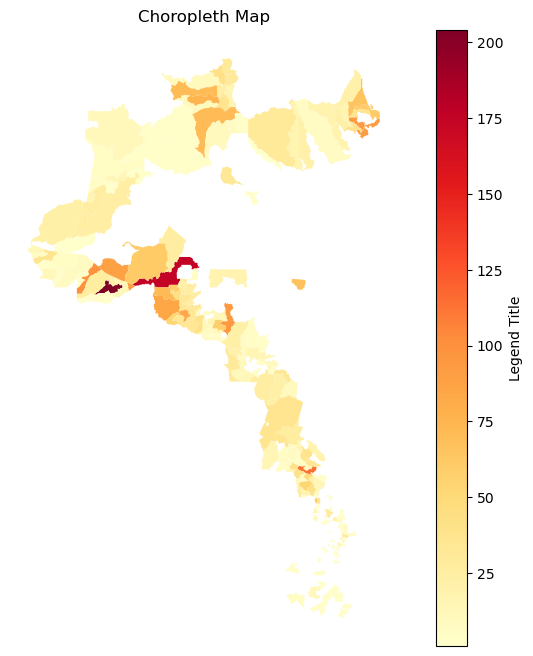

In [124]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your dataset
# gdf = gpd.read_file('path_to_your_dataset.geojson')  # Replace with the actual path

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Customize the plot appearance
gdf.plot(column='Total (2000-2021)', cmap='YlOrRd', ax=ax, legend=True,
         legend_kwds={'label': "Legend Title", 'orientation': "vertical"})
ax.set_title('Choropleth Map')
ax.set_axis_off()  # Turn off the axis

# Add labels to the polygons
# for idx, row in gdf.iterrows():
#     ax.annotate(text=row['MUN'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                 xytext=(3, 3), textcoords="offset points", fontsize=5, color='black')

plt.show()


### Mapas cloropeth com folium (Contagems por cidade por ano)

In [134]:
import folium
import geopandas as gpd

# Load your GeoDataFrame
# gdf = gpd.GeoDataFrame(history_shape, geometry='geometry')

latitude, longitude = -14.2350, -51.9253

cols = ['CONF' + str(year) for year in range(2000, 2022)] + ['Total (2000-2021)']
for col in cols:

    # Create a base map centered on a specific location
    m = folium.Map(location=[latitude, longitude], zoom_start=4)

    # Add choropleth layer to the map
    choropleth = folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=['id', col],  # Replace with the actual column names
        key_on='feature.properties.id',  # Adjust to match the property in your GeoJSON
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Conflitos',
        highlight=True  # Enable feature highlighting
    ).add_to(m)

    # Add tooltips to display information when hovering over features
    choropleth.geojson.add_child(
        folium.GeoJsonTooltip(fields=['id', col], aliases=['Cidade ID', f'Conflitos {col}'], labels=True)
    )

    # Display the map
    m.save(f'Mapas/Anuais/interactive_choropleth_map_{col[4:]}.html')
    print(col, 'Saved!')


CONF2000 Saved!
CONF2001 Saved!
CONF2002 Saved!
CONF2003 Saved!
CONF2004 Saved!
CONF2005 Saved!
CONF2006 Saved!
CONF2007 Saved!
CONF2008 Saved!
CONF2009 Saved!
CONF2010 Saved!
CONF2011 Saved!
CONF2012 Saved!
CONF2013 Saved!
CONF2014 Saved!
CONF2015 Saved!
CONF2016 Saved!
CONF2017 Saved!
CONF2018 Saved!
CONF2019 Saved!
CONF2020 Saved!
CONF2021 Saved!
Total (2000-2021) Saved!
